# Simple example of the delivered cost model

This notebook provides a simplified illustration of using raster_tools to perform the delivered cost model technique described in [Hogland et. al. 2021](https://www.mdpi.com/1999-4907/12/8/1084) for the extent of the Stanislaus National Forest (**~2.5 million acres @ 30m spatial resolution**).

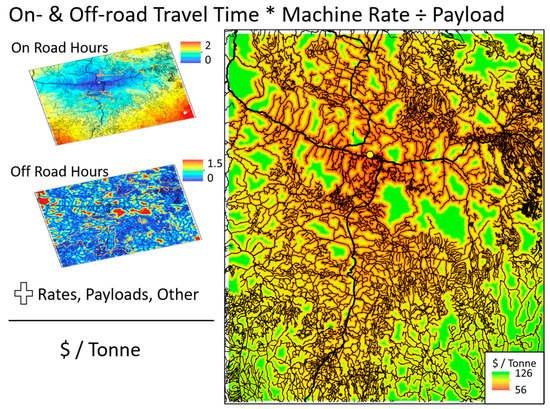

## Overview
1. Import raster_tools and add in raster and vector data. 
2. Visualize those data in a plot, as a dataframe/table, and as an interactive map.
3. Perform delivered cost routine
4. Visualize the results

Author: John Hogland

# Import raster_tools and add in raster and vector data
## Specify file paths

In [ ]:
flgeodb = '../data.gdb'
lyr_rds_path = 'roads'
lyr_fac_path = 'Facility'
lyr_nf_path = 'StanislausBoundary'
rs_elv_path = '../DEM30.tif'

## Import the raster_tools Raster and vector_open classes and surface and distance modules to perform analyses
Create Raster and Vector objects

In [ ]:
from raster_tools import Raster, open_vectors, surface, distance
rds,fac,nf = open_vectors(flgeodb,layers=[lyr_rds_path,lyr_fac_path,lyr_nf_path])
elv=Raster(rs_elv_path)

# Visualize your data
## As a plot

In [ ]:
p0 = nf.data.plot(facecolor="none",edgecolor='orange',zorder=3)
p1 = fac.data.plot(ax=p0,marker='o',markersize=30,color='red',zorder=4)
p2 = rds.data.compute().plot(ax=p1,color='gray',zorder=2) #need to compute due to size (#number of records) of rds
p3 = elv._rs.plot(ax=p2,zorder=1)

## As the full table (roads file)

In [ ]:
#Look at the full dask-geopanda structure. 
#Notice nothing is computed. 
#This is because it is a delayed dataframe (dask-geodataframe). 
#If we want to compute the cell values we must use the compute functon. 
rds.data 

### Just the attributes

In [ ]:
rds.table.compute() # look at the attribute values

### Just the geometry

In [ ]:
rds.geometry.compute() #Look at the geometry values

## Dynamic Mapping (Folium)

In [ ]:
import folium
from folium import plugins
m0=nf.data.explore(name='Stanislaus')
m1 = rds.data.compute().explore(m=m0,color='gray', name='Roads') #note for all the road examples we could have computed the geodataframe once instead of multiple times.
m2 = fac.data.explore(m=m1,color='red',name='Facilities')
folium.LayerControl().add_to(m2)
m2

# Delivered Cost Routine
## On Road Dollars Per Ton 
### Converting the speed attribute into a cost raster surface that can be used to calculate dollars per ton
Looking at the table you will notice the KPH field. This field denotes how fast a log truck can travel down a given road segment. We will use the roads geodataframe and the KPH field to convert our vector based road network into a raster surface of speed. 

To do this we will need to create a numba remap function and then:
1. use the to_raster of the rds object function to create a raster surface (zero values = null and cell values > 0 correspond to the dataframe row)
2. remap the speed values to the raster object
3. set zero values to null on the raster object
    
#### Creating a numba function for fast c like processing and a general remap function to remap vectors converted to a raster to a given vector attribute value     

In [ ]:
#definitions for remap function using 
from functools import partial
from numba import jit, prange
import numpy as np
@jit(nopython=True,nogil=True) #decorator to numba for compiling to C
def _remap_values(x,rmvls):
    outx=np.zeros_like(x)
    rws,clms=x.shape
    for rw in prange(rws):
        for cl in prange(clms):
            vl = int(x[rw,cl])
            if(vl==0): #zero values will be used for no data
               continue
            else:
                outx[rw,cl]=rmvls[vl-1] #use the raster value to find the index of the attribute row value (base 0)
            
    return outx

def remap_values(rs,vl_arr):
    outrs=rs.copy()
    data=outrs._rs.data
    func_remap_values=partial(_remap_values,rmvls=vl_arr) #partially assign parameter 
    #map our remap function to dask chunks for each band in the raster and reassign rasters to the xarray dataset
    for b in range(data.shape[0]):
        data[b] = data[b].map_blocks(func_remap_values,dtype=float, meta=np.array((), dtype=float)) #map block to address fast processing
    outrs._rs.data = data
    return outrs


### Convert vector to raster (step 1), remap values (step 2), set zero values to null data (step 3)
For step 2 we can save a great deal of processing by recognizing we want to convert distance measured in meters (elevation raster projection) to hours/ton (ht). To do this we can assume a log truck on average can carry **28** tons (bone dry) per load and with a little math can convert our segment speeds into hours/ton that can be input as a cost surface.

$
ht=1/((KPH*1000)/28)
$

Moreover, we can convert ht to dollars per ton (dt) by assuming a constant machine rate of **98** dollars per hour.

$
dt=ht*98
$


In [ ]:
#step 1
t1=rds.to_raster(elv) #convert to raster dataset (note the new raster cell values correspond to the row from the geodataframe)
t2=t1.astype(float) #covert the data type output to float

#step 2
dt=1/((rds.data['KPH'].compute().to_numpy()*1000)/28)*98 #extract values from dataframe and convert to dollars/ton
t3=remap_values(t2,dt)

#step 3
roadrs=t3.set_null_value(0)

#plot our new values and list the unique values
roadrs._rs.plot()
print(np.unique(roadrs.to_xarray().values))
print(np.unique(dt))

## Total Dollars Per Ton
### Calculating Off Road Dollars Per Ton
Now that we have our roads rate surface of dollars per ton per meter, we can use it (as a cost surface) in conjunction with our facility location (sawmill) and elevation surface to calculate the least accumulated travel cost along the roadway to the sawmill (zeros = null). To estimate travel costs from the forest to the roadways (skidding & yarding) we can use the same procedure to estimate the least accumulated cost to and along the roadway. To allocate on road dollars per ton to off road cells we can use off road surface allocation, on road dollar per ton, and arithmetic analyses to estimate a total dollars per ton at the cell level for the forested landscape.

### Converting Surface Distance Into Cost Measured In Dollars Per Ton (on road)
Using our roadrs surface of log truck hailing speeds, a constant log truck payload of **28** bone dry tones (green 46), a machine rate of **98** dollars per hour, and the distance module (cost_distance_analysis function) within raster_tools, we will create accumulated dollars per ton surface along the roadway. The cost_distance_analysis function takes costs, sources, and elevation surfaces as inputs to estimate the accumulated cost values for the least cost path. The steps to convert distance into costs are as follows:
1. Convert facilities to a raster (can have multiple facilities here)
2. Calculate on road costs 
3. Look at some stats and image

In [ ]:
#step 1: convert facilities vector to raster and set zero to null
t1=fac.to_raster(elv)
facrs=t1.set_null_value(0)

#step 2: calculate on road costs
on_tt, on_tb, on_all=distance.cost_distance_analysis(roadrs,facrs,elv)

#step 3: stats and image
on_tt._rs.plot()
print("Maxium on road cost $/ton = " + str(on_tt._rs.max().values))
xr = on_tt._rs
print("Minimum on road cost $/ton = " + str(xr.where(xr>0).min().values))
zc=(on_tt == 0)._rs.sum()
gc=(on_tt >= 0)._rs.sum()
print("Proportion of zeros on the landscape = " + str((zc/gc).values))#proportion of zeros


### Calculating off road costs and adding those costs to on road costs
Using our on_tt surface of dollars per ton, a constant rate of travel of **5.5** KPH, a constant skidder payload of **4** bone dry tones (green 8), a machine rate of **85** dollars per hour, and the distance module (cost_distance_analysis function) within raster_tools, we will create accumulated dollars per ton surface to the roadway. The cost_distance_analysis function takes costs, sources, and elevation surfaces as inputs to estimate the accumulated cost values for the least cost path. The steps to create off road costs and add those costs to on road costs are as follows:
1. Create inputs to the cost_distance analysis function
2. Calculate off road costs and allocate on road dollars/ton (in cents) to off road cells
3. Convert cents to dollars
4. Add on and off road dollar per ton surfaces
5. Look at stats and image

In [ ]:
#Step 1: create inputs
from raster_tools import creation
dt=creation.constant_raster(elv,value=1/((5.5*1000)/4)*85) #creating a constant raster that converts distance to $\ton 
dt=dt.set_null_value(0) #need to set null value so we can define null values 
on_tt_cents=(on_tt*100).astype(int) #cost_distance_analysis needs the source raster to be an int. Changed on_tt to cents 

#Step 2: calculate on and off road costs
off_tt, off_tb, off_all = distance.cost_distance_analysis(dt,on_tt_cents,elv) #run the cost distance

#Step 3: convert cents to dollars
on_tt_alc=off_all/100 #convert cents to dollars again

#Step 4: Add on and off road costs
cost=off_tt+on_tt_alc

#Step 5: Look at stas and image
print('max cost ($/ton) = ' + str(cost._rs.max().values))
cost._rs.plot()

# Visualizing The Results Within Folium
To visualize our dollar per ton raster in Folium we need to:
1. Normalize the data and get color map
2. Reproject the data to lat and lon
3. Build out the map

In [ ]:
from matplotlib import cm

#Step 1: Normalize the data and get color map
l=cost._rs[0].min().values.item()
u=cost._rs[0].max().values.item()
costn=(cost-l)/(u-l)
cmap=cm.get_cmap('coolwarm')


#Step 2: reproject to lat lon
xds_utm = costn._rs.rio.reproject("epsg:4326") #we need to reproject our results to lat lon
w,s,e,n=xds_utm.rio.bounds() #get the bounds
bnd = [[s,w],[n,e]] #set the bound for folium
data=cmap(xds_utm[0])

#Step 3: build out the map
m0=nf.data.explore(name='Stanislaus')
folium.raster_layers.ImageOverlay(image=data,bounds=bnd,mercator_project=True,name='cost').add_to(m0) #add the raster
#add the colormap
#m0.add_child(cmap)
m1 = rds.data.compute().explore(m=m0,color='brown',name='roads')
m2 = fac.data.explore(m=m1,color='red',name='facility')
fs=plugins.Fullscreen()
m2.add_child(fs)
folium.LayerControl().add_to(m2) # add the layer control
m2.fit_bounds(bnd) #zoom the map to bounds of the cost raster
m2 #view the map

## There are many ways to customize these layers and add functionality. Check out Folium for more details.
https://python-visualization.github.io/folium/index.html

Now, let's save our interactive map as an html file that we can share with others.

In [ ]:
m2.save("test.html")

## This ends the delivered cost example.